In [1]:
#%load_ext line_profiler
#%%prun  -D train.prof -s cumulative -q -T prun0
#print(open('prun0', 'r').read())
#%snakeviz 1 + 2

In [2]:
#from torch.profiler import profile, record_function, ProfilerActivity
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("train_model"):
#        models, trainers = train_model(model_type, data_modules, model_args, verbose=True)
#prof.key_averages().table(sort_by="cuda_time_total", row_limit=10)

In [3]:
import os
import math
import random
import copy
        
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from data_utils import SeqDataModule

In [4]:
show_umap = False

if show_umap:
    # plot umap
    dm = data_modules[0]
    dm.setup()  # remove NaNs and normalize
    train_dl = dm.train_dataloader()
    train_inputs = train_dl.dataset.inputs
    train_targets = train_dl.dataset.targets

    from umap import UMAP
    import umap.plot

    flat_inputs = np.concatenate(train_inputs, axis=0)
    flat_targets = np.concatenate(train_targets, axis=0)
    mask = ~np.isnan(flat_targets)
    flat_inputs = flat_inputs[mask]
    flat_targets = flat_targets[mask]

    mapper = UMAP(n_components=2)
    umapped_inputs = mapper.fit_transform(flat_inputs)

    umap.plot.points(mapper, values=flat_targets, theme="fire")

In [5]:
# NaN filling debug plots

# plot data
#train_inputs = train_dl.dataset.inputs
#val_inputs = val_dl.dataset.inputs
#print("Lens train val:", len(train_inputs), len(val_inputs))


#pat_idx = 12
#feat_idx = 5

#feat_name = feature_names[feat_idx]
##print(model.mean[0, feat_idx])
#pat_data = train_inputs[pat_idx][:, feat_idx]
#print(pat_data.min())
#print(torch.isnan(pat_data).sum())
#plt.plot(pat_data)
##plt.title(f"Progression of {feat_name}")
#plt.ylabel(feat_name)
#plt.xlabel("time")

#nan_again = train_inputs[pat_idx][:, feat_idx]
#plt.scatter(range(len(nan_again)), nan_again)
#plt.show()
#print(np.isnan(nan_again).sum())
#print(nan_again.shape)

In [6]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [7]:
from train_utils import default_args

args, model_args = default_args()

In [10]:
"""
self.add_float(trial, "lr", [0.00003, 0.005])
self.add_float(trial, "grad_clip_val", [0.1, 10.0])
self.add_int(trial, "hidden_size", [64, 1024])
self.add_float(trial, "dropout", [0.0, 0.5])
# need to set bs manually
bs = trial.suggest_int("bs", 1, 7)
for dm in self.data_modules:
    dm.batch_size = 2 ** bs 

if self.model_type == "rnn":
    self.add_int(trial, "rnn_layers", [1, 5])
    self.add_cat(trial, "rnn_type", ["lstm", "gru"])

if self.model_type == "transformer":
    self.add_int(trial, "n_layers", [1, 10])
    self.add_int(trial, "n_heads", [1, 16])
    self.add_int(trial, "emb_dim", [32, 1024])
"""
a = 1

In [ ]:
model_args["rnn_layers"] = 10
model_args["bs"] = 2 ** 5
model_args["hidden_size"] = 512

model_args["n_layers"] = 3
model_args["n_heads"] = 4
model_args["emb_dim"] = 256


# model args
model_args["dropout"] = 0.1
model_args["rnn_type"] = "lstm"
# transfomrer

model_args["max_steps"] = 500
model_args["lr"] = 0.05
args["model_type"] = "lucid_transformer"
args["dbs"] = ["UKE"]

In [ ]:
model_args

In [ ]:
embed_dim = model_args["emb_dim"]
num_heads = model_args["n_heads"]

head_dim = embed_dim // num_heads
print(head_dim)
#assert head_dim * num_heads == embed_dim

In [11]:
from data_utils import get_seq_list, make_split, do_fold

# choose feats
#no_meds = [name for name in feature_names if "_Med" not in name and "Diagnose" not in name]
#args["features"] = no_meds # no_meds

# load data
seq_list = get_seq_list(args["minutes"], False, "ICP_Vital", args["features"])

# dev test split
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)
# train val splits
data_modules = do_fold(dev_data, test_data, 
                       args["dbs"], 
                       model_args["random_starts"], 
                       model_args["min_len"], 
                       model_args["train_noise_std"],
                       model_args["bs"],
                       model_args["fill_type"], 
                       args["flat_block_size"],
                       k_fold=args["k_fold"], 
                       num_splits=args["num_splits"],
                      )

train_dl = data_modules[0].train_dataloader()
val_dl = data_modules[0].val_dataloader()
num_features = train_dl.dataset.inputs[0].shape[-1]
feature_names = train_dl.dataset.feature_names

print(feature_names)

Reading df from:  data/60_/yeo_N/normalization_None/median/uni_clip_0.9999/multi_clip_N/df.pkl
['rel_time', 'AF_Vital', 'AF_Vital_max', 'AF_Vital_min', 'AF_Vital_std', 'ALT_Labor', 'AST_Labor', 'Alpha Blocker_Med', 'Benzodiazepin_Med', 'Ca_BGA', 'Cl_BGA', 'Direkter Vasodilatator_Med', 'EVB_Labor', 'FiO2_Vital', 'FiO2_Vital_std', 'Freq gesamt_Vital', 'Freq spontan_Vital', 'GCS_auge_Vital', 'GCS_motor_Vital', 'GCS_total_Vital', 'GCS_verbal_Vital', 'Glu_BGA', 'HCO3_BGA', 'HF_Vital', 'HF_Vital_max', 'HF_Vital_min', 'HF_Vital_std', 'Harnstoff-N_Labor', 'Hb_BGA_BGA', 'Hk_Labor', 'INR_Labor', 'K_BGA', 'Katecholamin_Med', 'Kreatinin_Labor', 'Lac_BGA', 'MCHC_Labor', 'MCH_Labor', 'MCV_Labor', 'Magnesium_Labor', 'Na_BGA', 'Narkotikum_Med', 'Opioid_Med', 'PCO2_BGA', 'PEEP_Vital', 'PO2_BGA', 'Phosphat_Labor', 'Pmean_Vital', 'Ppeak_Vital', 'Pupille li_Vital', 'Pupille re_Vital', 'SBE_BGA', 'SpO2_Vital', 'SpO2_Vital_max', 'SpO2_Vital_min', 'SpO2_Vital_std', 'TZ_Labor', 'Temp_Vital', 'Temp_Vital_std',

In [51]:
feature_names[0]

'rel_time'

In [53]:
len(feature_names)

96

In [56]:
data_modules[0].train_ds.inputs[0].shape

torch.Size([145, 96])

tensor([-1.6625e+00, -6.7071e-01, -4.6287e-01, -7.7160e-01,  1.8987e+00,
        -3.1350e-01, -4.3504e-01, -8.9948e-01, -1.8473e+00,  7.9975e-02,
         3.1691e-01, -8.3937e-01, -1.3887e-02, -6.8793e-01,  1.4128e+00,
        -1.0070e+00,  1.9670e+00, -4.0324e-01,  2.5708e+00,  1.0347e+00,
        -5.8320e-01,  5.5381e-01, -4.4288e-02, -2.2325e-01, -2.3285e-01,
        -2.1468e-01, -3.5167e-01, -5.7792e-01,  4.2359e-01,  1.1258e-03,
        -6.1625e-02,  8.0675e-02, -5.2140e-01, -1.0580e-01,  2.5797e-01,
        -3.3739e-02, -3.3363e-02, -2.2075e-02,  1.3320e-01,  6.1410e-02,
        -6.7700e-01, -1.9613e-01,  1.2580e-01, -5.8782e-01, -7.8342e-02,
         1.7427e-01, -1.3139e+00, -1.6550e+00, -8.4920e-01, -9.1646e-01,
        -8.1586e-01,  2.6504e-01,  2.7065e-01,  2.5405e-01,  1.3421e+00,
        -2.1437e-01,  1.5153e-01,  3.5247e-01, -3.2729e-02, -1.3056e-01,
         5.1404e-01,  5.1534e-01,  5.2097e-01,  2.3907e-01, -1.1037e+00,
        -1.1146e+00, -1.0571e+00, -5.4788e-01,  4.6

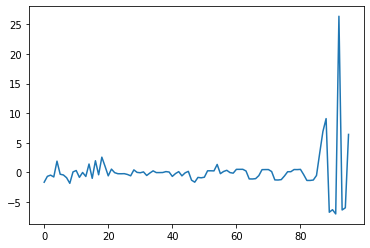

In [60]:
input_batch = next(iter(data_modules[0].train_dataloader()))[0]
print(input_batch[0][0])
plt.plot(range(len(input_batch[0][0])), input_batch[0][0])

In [63]:
data_modules[0].train_ds[0].shape

AttributeError: 'tuple' object has no attribute 'shape'

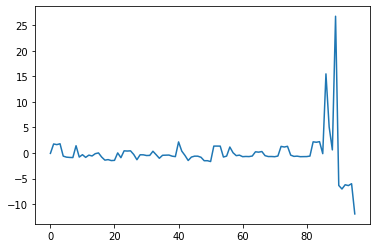

In [74]:
plt.plot(data_modules[0].train_ds[0][0][0])

In [81]:
len(data_modules[0].train_ds.raw_inputs)

760

torch.Size([145, 96])


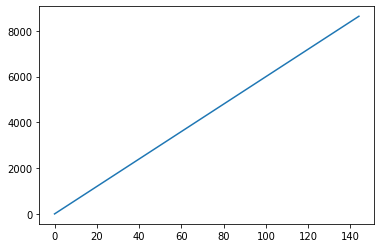

In [88]:
first_pat = data_modules[0].train_ds.raw_inputs[0]
print(first_pat.shape)
plt.plot(first_pat[:, 0])

In [106]:
data_modules[0].mean

tensor([ 8.3389e+03,  1.4604e+01,  1.4894e+01,  1.4404e+01,  1.9114e-01,
         4.6880e+00,  7.1607e+00, -1.8695e+00, -1.1926e+00,  4.8636e-01,
         4.2652e+01, -7.5060e+00,  1.7448e+00,  2.3701e+01,  5.8411e-02,
         1.3789e+01,  1.8868e+00,  8.7881e-01,  1.0138e+00,  2.6262e+00,
         7.5685e-01,  5.8272e+01,  1.0438e+01,  6.9570e+01,  7.0338e+01,
         6.8812e+01,  6.5128e-01,  4.0606e-01,  4.0997e+00,  3.5016e+00,
         1.3118e-01,  1.6989e+00, -1.5542e-01,  9.7008e-02,  5.4310e-01,
         4.2969e+00,  3.9056e+00,  1.1518e+01,  7.8967e-02,  5.9197e+01,
        -8.7389e-01, -7.1619e-01,  1.5411e+01,  5.3540e+00,  3.7315e+01,
         8.7433e-02,  8.6492e+00,  1.6798e+01,  1.5651e+00,  1.5659e+00,
         4.2822e-01,  8.6705e+01,  8.6854e+01,  8.6549e+01,  1.4632e-01,
         2.6881e+00,  3.0337e+01,  1.3060e-02,  2.7964e+01,  4.6491e+00,
         6.7305e+00,  6.8655e+00,  6.5365e+00,  5.1415e-02,  5.7196e+01,
         5.8205e+01,  5.6197e+01,  8.7731e-01,  9.5

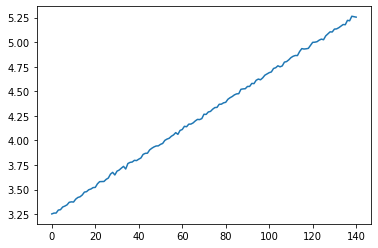

In [103]:
feats = data_modules[0].train_ds[3][0][:, 0]
plt.plot(feats)

In [45]:
next(iter(data_modules[0].train_dataloader()))[2]

tensor([247,  63, 230,  64,  57,  54, 355,  38])

In [37]:
data_modules[0].train_ds.flat_inputs.shape

(191068, 96)

In [109]:
mean_train_target = np.concatenate([pat[~torch.isnan(pat)].numpy() for pat in train_dl.dataset.targets]).mean()#np.mean([pd.Series(pat).mean() for pat in train_dl.dataset.targets])
print("Mean train target: ", mean_train_target)

total_icps = np.sum([(~pd.Series(pat).isna()).sum() for pat in train_dl.dataset.targets])
total_steps = np.sum([len(pat) for pat in train_dl.dataset.targets])
print("Total steps: ", total_steps)
print("Total ICP training targets: ", total_icps)

Mean train target:  13.053722766145164
Total steps:  191068
Total ICP training targets:  150238


In [ ]:
from data_utils import SequenceDataset, seq_pad_collate

#external_db_names = [db for db in all_dbs if db not in args["dbs"]]
#print("External validation dbs: ", external_db_names)
#external_datasets = [SequenceDataset(seq_list, "ICP_Vital", train=False, random_starts=False, block_size=0, 
#                         train_noise_std=0.0, dbs=[db]) for db in external_db_names]
#external_dls = {db_name: torch.utils.data.DataLoader(ds, batch_size=model_args["bs"] * 4, collate_fn=seq_pad_collate) for db_name, ds in zip(external_db_names, external_datasets)}

In [110]:
# train
#model_args["lr"] = 0.005
model_args["max_steps"] = 200

classical_models = ["linear", "xgb", "rf"]
nn_models = ["mlp", "rnn", "transformer"]
# Choose:
#model_type = "xgb" # ["linear", "xgb"], ["mlp", "rnn", "transformer"]

In [137]:
model_args["lr"] = 0.0001
model_args["max_steps"] = 500
args["model_type"] = "xgb"

In [138]:
from train_utils import train_model

models, trainers = train_model(args["model_type"], data_modules, model_args, verbose=True)

Input, target shape:  (150238, 96) (150238,)
Input, target shape:  (153585, 96) (153585,)
Input, target shape:  (150816, 96) (150816,)


In [139]:
from data_utils import seq_pad_collate

def traini(bs, num_workers, pin):
    dl = torch.utils.data.DataLoader(data_modules[0].train_ds, batch_size=bs, num_workers=num_workers, pin_memory=pin, collate_fn=seq_pad_collate)
    model = create_model(model_type, data_modules[0], model_args)
    trainer = create_trainer(model_args, verbose=False)
    trainer.fit(model, dl)

In [140]:
from eval_utils import get_all_dfs, print_all_metrics

# eval
dl_type = "test"
#dl = external_dls["MIMIC"] # external_dls - MIMIC, eICU, UKE
calc_new_norm_stats = True
dl = None

df = get_all_dfs(models, trainers, args["model_type"], dl_type=dl_type, dl=dl, calc_new_norm_stats=calc_new_norm_stats)

In [141]:
df

,targets,preds,ids,step,error,mean_train_target,model_id
0,19.000000,18.128492,0,0,0.759526,13.053723,0
1,18.000000,19.804688,0,1,3.256897,13.053723,0
2,19.250000,16.981329,0,2,5.146868,13.053723,0
3,13.666667,30.811781,0,3,293.954932,13.053723,0
4,12.333333,48.291965,0,4,1293.023249,13.053723,0
...,...,...,...,...,...,...,...
60277,-0.500000,11.704804,232,261,148.957251,13.016913,2
60278,4.000000,9.937780,232,262,35.257236,13.016913,2
60279,8.000000,11.363655,232,263,11.314176,13.016913,2
60280,6.000000,9.953321,232,264,15.628751,13.016913,2


In [142]:
print_all_metrics(df)

Performance over splits: 
            targets      preds      error
model_id                                 
0         13.203527  13.473685  77.723793
1         13.203527  13.675105  79.354236
2         13.203527  13.327634  80.902869
Mean train target:  13.053722766145164
Mean/Std preds:  13.598003 7.0178623
Mean/Std targets:  13.203526552941277 11.068664597496733
Max error:  7212.454410167935
Accuracy for hypertension baseline:  0.9147020163883994

Model metrics:
RMSE:  8.906568707631719
MSE:  79.32696614376455
MAE:  5.684785392040176
MAPE:  0.43055053278730354
R2 custom:  0.3525094622335089
R2:  0.35250946223350904
R2 old:  0.3525094622335089
Accuracy for hypertension:  0.9147020163883995
Precision for hypertension:  0.42127419417889067
Recall for hypertension:  0.33740853940909515

Mean train baseline metrics:
Mean train target: 13.053722766145164
RMSE:  11.06963958598189
MSE:  122.5369205635373
MAE:  6.338916477820832
MAPE:  0.4800926822394087
R2 custom:  -8.280620603306957
R2 sc

(0.0, 5000.0)

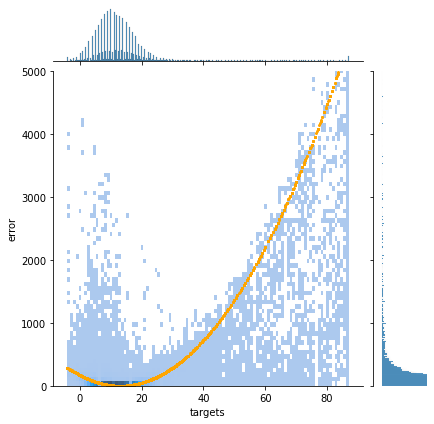

In [143]:
df_nona = df[~df.isna()]
mean_pred_error = (df_nona["targets"] - mean_train_target).dropna() ** 2
ax = sns.jointplot(x="targets", y="error", data=df_nona, kind="hist", bins=100) # data=by_pat
ax.ax_joint.scatter(df_nona["targets"], (np.ones(len(df_nona["targets"])) * mean_train_target - df_nona["targets"]) ** 2, s=2, color="orange")
plt.xlim(-20, 105)
plt.ylim(0, 5000)

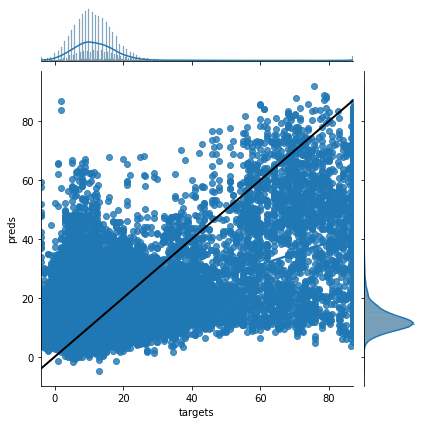

In [144]:
ylim = (df_nona["preds"].min() - 5, df_nona["preds"].max() + 5)
ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
min_val = df_nona["targets"].min()
max_val = df_nona["targets"].max()
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black", label="Ideal model")

-4.0 87.0


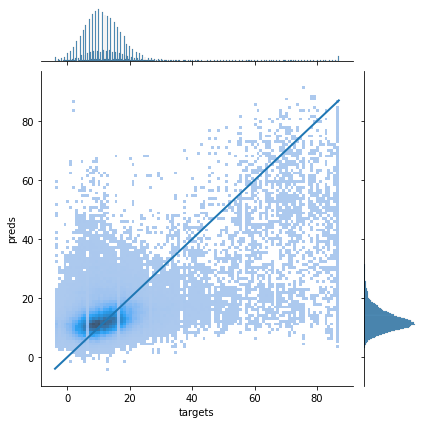

In [145]:
ax = sns.jointplot(data=df_nona, x="targets", y="preds", kind="hist", bins=100, ylim=ylim)
print(min_val, max_val)
# draw line of perfect correlation
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [154]:
#pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 16)
pats = df.groupby("ids").filter(lambda x: x['targets'].mean() > 30)
#pats = df.groupby("ids").filter(lambda x: np.sqrt(x['error'].mean()) > 30)

pats = pats.groupby("ids").filter(lambda x: len(x["targets"].dropna()) > 2)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[ 12  15  29  49  51  84  89 104 105 110 125 136 142 144 146 147 149 154
 159 169 177 206 207 210 224 229 230]
27 patients


mean average target:  13.053722766145164
mean pat targets:  32.65425531914894
RMSE of model: 24.62
RMSE of mean: 31.93
MAPE of model:  0.49
MAPE of mean:  0.62


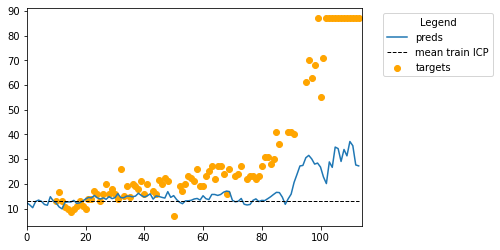

In [155]:
from eval_utils import mape

pat_id = 0
model_id = 0

pat = df[df["ids"] == ids[pat_id]]
pat = pat[pat["model_id"] == model_id]
plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = mean_train_target
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean train ICP", linestyle="--")
#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
pat_nona = pat[~pat["targets"].isna()]
print("RMSE of model:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], pat_nona["preds"])), 2))
print("RMSE of mean:", round(np.sqrt(sklearn.metrics.mean_squared_error(pat_nona["targets"], [mean] * len(pat_nona))), 2))
print("MAPE of model: ", round(mape(pat_nona["targets"], pat_nona["preds"]), 2))
print("MAPE of mean: ", round(mape(pat_nona["targets"], [mean] * len(pat_nona)), 2))

## Saliency

In [156]:
import shap


def classical_saliency(models, trainers, model_type, use_shap=False, verbose=True):
    # plot feature importance
    all_importances = []
    all_inputs = []
    for model, data_module in zip(models, trainers):
        if use_shap:
            explainer = shap.TreeExplainer(model)
            inputs = data_module.test_dataloader().dataset.flat_inputs
            importances = explainer.shap_values(inputs)
            all_inputs.append(inputs)
        else:
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
            elif hasattr(model, "coef_"):
                importances = model.coef_
        all_importances.append(importances)
    if verbose and hasattr(model, "importance_type"):
        print("Importance type: ", model.importance_type)
    mean_importances = np.mean(np.stack(all_importances), axis=0)
    path = f"outputs/{model_type}"
    os.makedirs("outputs", exist_ok=True)
    
    if use_shap:
        #shap.summary_plot(mean_importances, X_test, plot_type="bar")
        #shap.summary_plot(mean_importances, X_test)
        #shap.summary_plot(mean_importances)
        #input_df = pd.DataFrame(inputs, columns=feature_names)
        #shap_df = pd.DataFrame(mean_importances, columns=feature_names)
        
        #vals= np.abs(shap_values).mean(0)
        #feature_importance = pd.DataFrame(list(zip(feature_names, vals)),columns=['col_name','feature_importance_vals'])
        #feature_importance = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False)
        #feature_importance.head()
        if verbose:
            shap.summary_plot(mean_importances, features=inputs, feature_names=feature_names)
            plt.savefig(path + "_shap_importances.jpg", bbox_inches='tight')
        
        imp_per_feat = np.abs(mean_importances).mean(axis=0)
        feat_df = pd.Series(imp_per_feat, index=feature_names)
    else:
        # make plot
        feat_df = pd.Series(mean_importances, index=feature_names)
        if verbose:
            p = feat_df.sort_values().plot.barh(figsize=(4, 25))
            p.figure.savefig(path + "_importances.jpg", bbox_inches='tight')
        
    feat_df = feat_df.sort_values(ascending=True)
    return feat_df


def reduce_feat_df(feat_df, threshold=0.2):
    # remove everything above 90% explained importance
    print(len(feat_df))
    feat_df = feat_df / feat_df.sum()
    reduced_df = feat_df[feat_df.cumsum() > 0.2]
    print(len(reduced_df))
    print(reduced_df)
    reduced_feats = list(reduced_df.index)
    return reduced_feats


2021-11-03 14:09:29.761274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-03 14:09:29.761320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Importance type:  gain


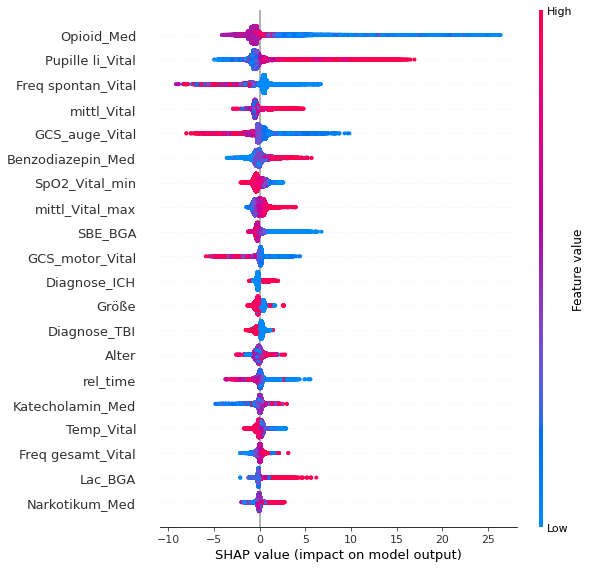

<Figure size 432x288 with 0 Axes>

In [159]:
sal_df = classical_saliency(models, trainers, args["model_type"], use_shap=True, verbose=True)

In [160]:
reduced_feats = reduce_feat_df(sal_df, threshold=0.2)

96
37
ALT_Labor             0.006599
Geschlecht            0.006802
SpO2_Vital_max        0.006817
AF_Vital_std          0.007692
INR_Labor             0.008175
syst_Vital_max        0.008496
diast_Vital_max       0.008758
HF_Vital_min          0.009101
PO2_BGA               0.009284
Cl_BGA                0.009521
PEEP_Vital            0.009627
Na_BGA                0.011820
PCO2_BGA              0.011968
FiO2_Vital            0.012290
Ppeak_Vital           0.012842
Pupille re_Vital      0.012915
Gewicht               0.013839
Narkotikum_Med        0.014173
Lac_BGA               0.015163
Freq gesamt_Vital     0.015708
Temp_Vital            0.016700
Katecholamin_Med      0.017250
rel_time              0.019159
Alter                 0.020336
Diagnose_TBI          0.020472
Größe                 0.020477
Diagnose_ICH          0.022855
GCS_motor_Vital       0.024767
SBE_BGA               0.026270
mittl_Vital_max       0.027281
SpO2_Vital_min        0.029208
Benzodiazepin_Med     0.039338
GC

In [162]:
from saliency import get_sal_list

sal_list = []

for model in models:
    model_saliency = get_sal_list(model, 0, perc=1.0, agg=True, ds=model.data_module.test_dataloader().dataset, ig=False)
    sal_list += model_saliency

AttributeError: 'XGBRegressor' object has no attribute 'data_module'

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
mean_overall = [s.mean(0) for s in sal_list]
feat_saliency = np.sum(mean_overall, axis=0)

In [ ]:
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

In [ ]:
plt.figure()
p = feat_sal_df.plot.barh(figsize = (6, 25))

In [ ]:
p.figure.savefig("importances.jpg", bbox_inches='tight')

In [ ]:
plt.show()

# Tuning

In [ ]:
from tune_utils import tune#, make_tune_plots
from data_utils import make_split

import importlib
import tune_utils
importlib.reload(tune_utils)
from tune_utils import tune

import data_utils
importlib.reload(data_utils)

In [ ]:
import logging
import pytorch_lightning

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
logging.getLogger("lightning").setLevel(logging.ERROR)
pytorch_lightning.utilities.distributed.log.setLevel(logging.ERROR)

In [ ]:
args["dbs"] = ["UKE"]
args["k_fold"] = 0
args["num_splits"] = 3
args["flat_block_size"] = 0
args["n_trials"] = 15
args["model_type"] = "linear"
args["fill_type"] = "pat_mean"

model_args["max_steps"] = 300

opt_flat_block_size = False
opt_augs = False
opt_fill_type = False

In [ ]:
#storage = optuna.storages.RDBStorage(url="sqlite:///optuna.db",
#                                         engine_kwargs={"connect_args": {"timeout": 30}})
#load_study = optuna.load_study("09_17_02_39__linear_UKE_15", storage=storage)

In [ ]:
# make dev/test split to test tuning
dev_data, test_data, dev_idcs, test_idcs = make_split(seq_list, test_size=0.2)

In [ ]:
# tune
study = tune(dev_data, test_data, args, model_args, verbose=False, n_trials=args["n_trials"],
             opt_flat_block_size=opt_flat_block_size, opt_augs=opt_augs, opt_fill_type=opt_fill_type)

In [ ]:
#test_idcs = np.load("test_tune/09_17_02_39__linear_UKE_15/test_idcs.npy")

In [ ]:
# print key study parts
name = study.study_name
print(name)
print(study.best_trial)
best_params = study.best_params
print(best_params)

In [ ]:
from tune_utils import store_study_results
store_study_results(study, "./test_tune/", test_idcs, args)

In [ ]:
make_tune_plots(study, f"outputs/tune_results/{args['model_type']}_{args['n_trials']}")

In [ ]:
# retrain on dev/test and check performance
    
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

In [ ]:
args["k_fold"] = 0
args["num_splits"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

In [ ]:
args["k_fold"] = 5
models, trainers = retrain(dev_data, test_data, best_params, args, model_args, verbose=True)

## Nested k-fold

In [ ]:
classical_models = ["xgb", "rf", "linear"]

In [ ]:
args["dbs"] = ["UKE"]
args["k_fold"] = 0
args["num_splits"] = 3
args["flat_block_size"] = 1
args["n_trials"] = 10

args["n_outer_folds"] = 3

args["model_type"] = "xgb"
args["fill_type"] = "pat_mean"

In [ ]:
from data_utils import make_fold
# outer fold
dev_data_list, test_data_list, dev_idcs, test_idcs = make_fold(seq_list, k=args["n_outer_folds"])

In [ ]:
# tune and store studies
studies = []
for dev_data, test_data in zip(dev_data_list, test_data_list):
    study = tune(dev_data, test_data, args, model_args, verbose=False, n_trials=args["n_trials"])
    # print key tune details
    name = study.study_name
    print(name)
    print(study.best_trial)
    best_params = study.best_params
    print(best_params)
    studies.append(study)

In [ ]:
metrics = []
pred_dfs = []
for tune_idx in tqdm(range(len(studies))):
    models, trainers = retrain(dev_data_list[tune_idx],
                               test_data_list[tune_idx], 
                               studies[tune_idx].best_params, 
                               args, model_args, verbose=False)
    df = get_all_dfs(models, trainers, args["model_type"], dl_type="test")
    #loss = print_all_metrics(df)
    loss = df.groupby("model_id").apply(lambda model_df: model_df.groupby("ids").mean()).mean()["error"]
    metrics.append(loss)
    pred_dfs.append(df)
    print(loss)

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
[study.best_value for study in studies]

In [ ]:
metrics

In [ ]:
print(np.mean(metrics))
print(np.std(metrics))

In [ ]:
for study in studies:
    print(study.best_value)
    print(study.best_params)
    print()

In [ ]:
metrics

In [ ]:
len(studies)

In [ ]:
studies[0].best_trial